In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
data_directory = 'Data/data-bls-gov/Average_Weekly_Earnings'  # Excel file paths
xlsx_files = [os.path.join(data_directory, f) for f in os.listdir(data_directory) if f.endswith('.xlsx')]

In [3]:
# Create a list to store data and table names
data_list = []


for f in xlsx_files:
    df = pd.read_excel(f)
    table_name = os.path.splitext(os.path.basename(f))[0]
    df['table_name'] = table_name
    data_list.append(df)

# Merge ALL 
# All individual excel files contain very small data, with the overall amount not exceeding 3MB.
df = pd.concat(data_list)


In [4]:
# Extract Construction and CES2000000011, delete .xlsx first
df['table_name'] = df['table_name'].str.replace('.xlsx', '')
df['industry'] = df['table_name'].str.split('_').str[0]
df['CES'] = df['table_name'].str.split('_').str[1]

In [5]:
# Delete the row with Year=2024, because it is an analysis of years and there is insufficient data in 2024
df = df[df['Year'] != 2024]

In [6]:
# 读取CSV文件  
df = pd.read_csv('Average_Weekly_Earnings_summary.csv')

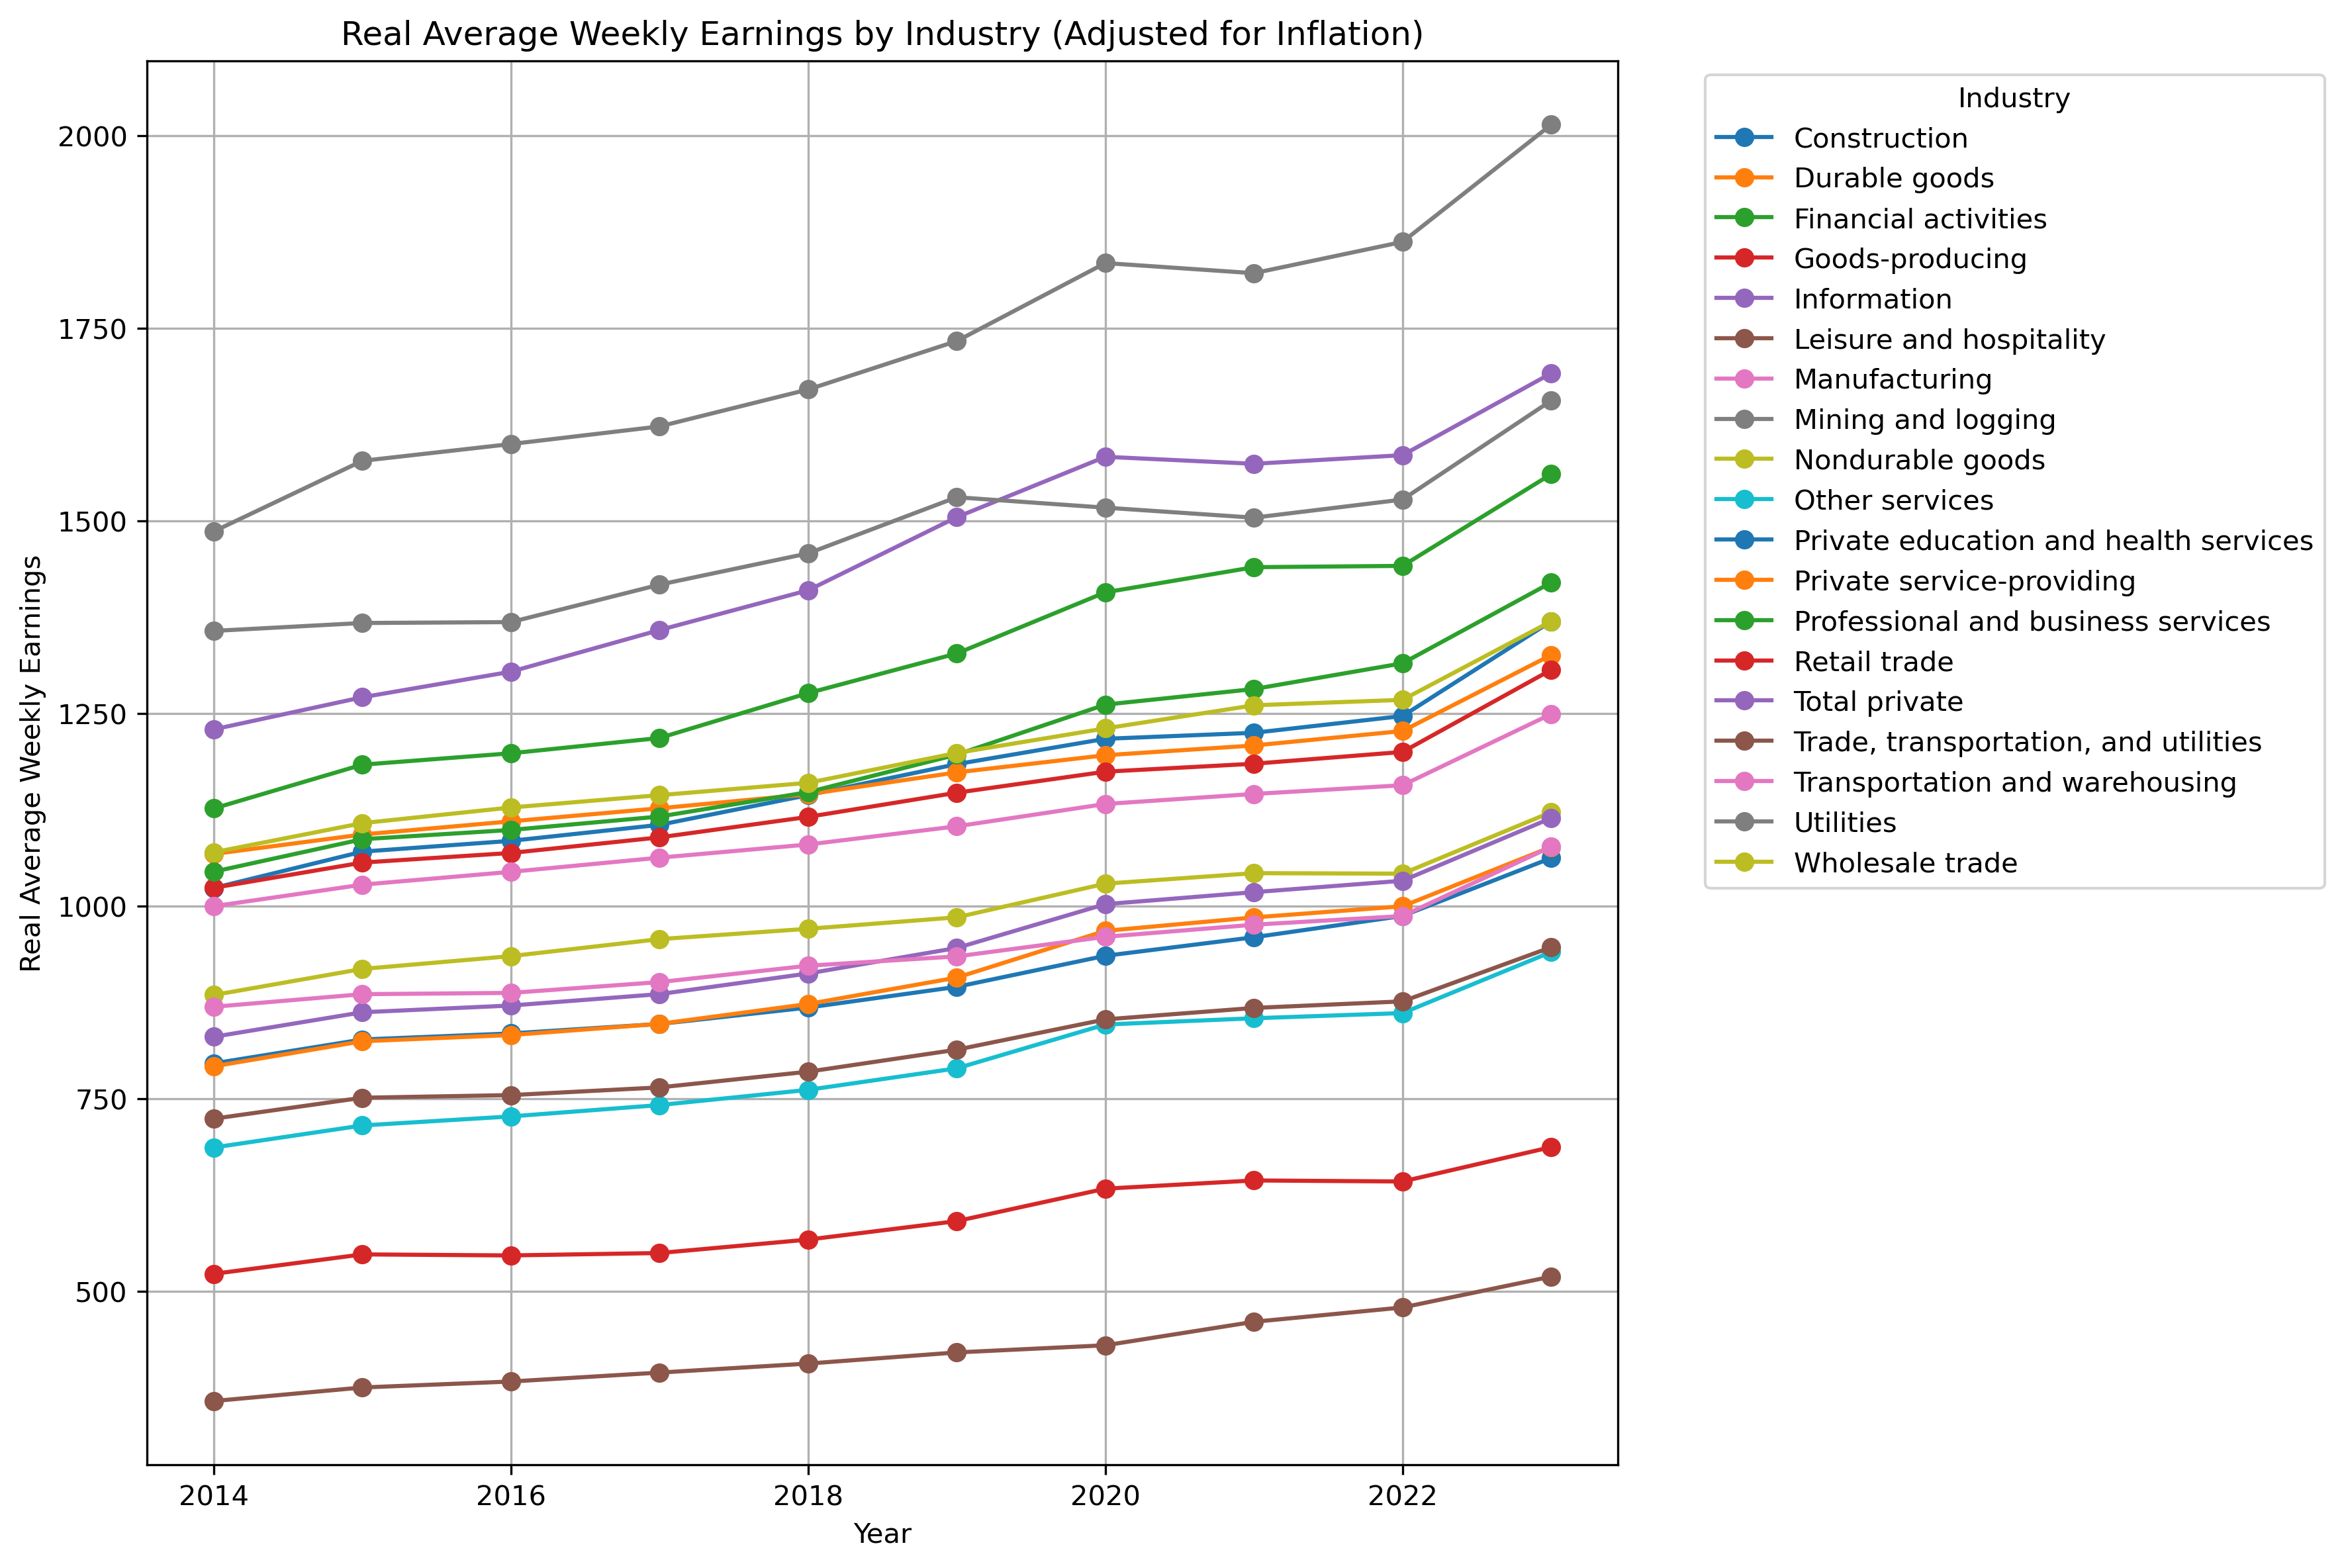

In [7]:
# Inflation rates from 2014 to 2023
# From: https://www.usinflationcalculator.com/
inflation_rates = {
    2014: 0.016,
    2015: 0.001,
    2016: 0.013,
    2017: 0.021,
    2018: 0.024,
    2019: 0.018,
    2020: 0.012,
    2021: 0.047,
    2022: 0.080,
    2023: 0.041
}

# New line for average 
df['average'] = df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].mean(axis=1)
# Calculate the real average wage for each year adjusting for inflation
df['real_average'] = df.apply(lambda row: row['average'] / (1 + inflation_rates[row['Year']]), axis=1)

# Now we'll plot the real wage data


# Group data by industry and Year for plotting
df_grouped = df.groupby(['industry', 'Year'])['real_average'].mean().unstack()

# Setup plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

# Plot each industry
for industry in df_grouped.index:
    ax.plot(df_grouped.columns, df_grouped.loc[industry], label=industry, marker='o')

# Customizing the plot
ax.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_title('Real Average Weekly Earnings by Industry (Adjusted for Inflation)')
ax.set_xlabel('Year')
ax.set_ylabel('Real Average Weekly Earnings')
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()


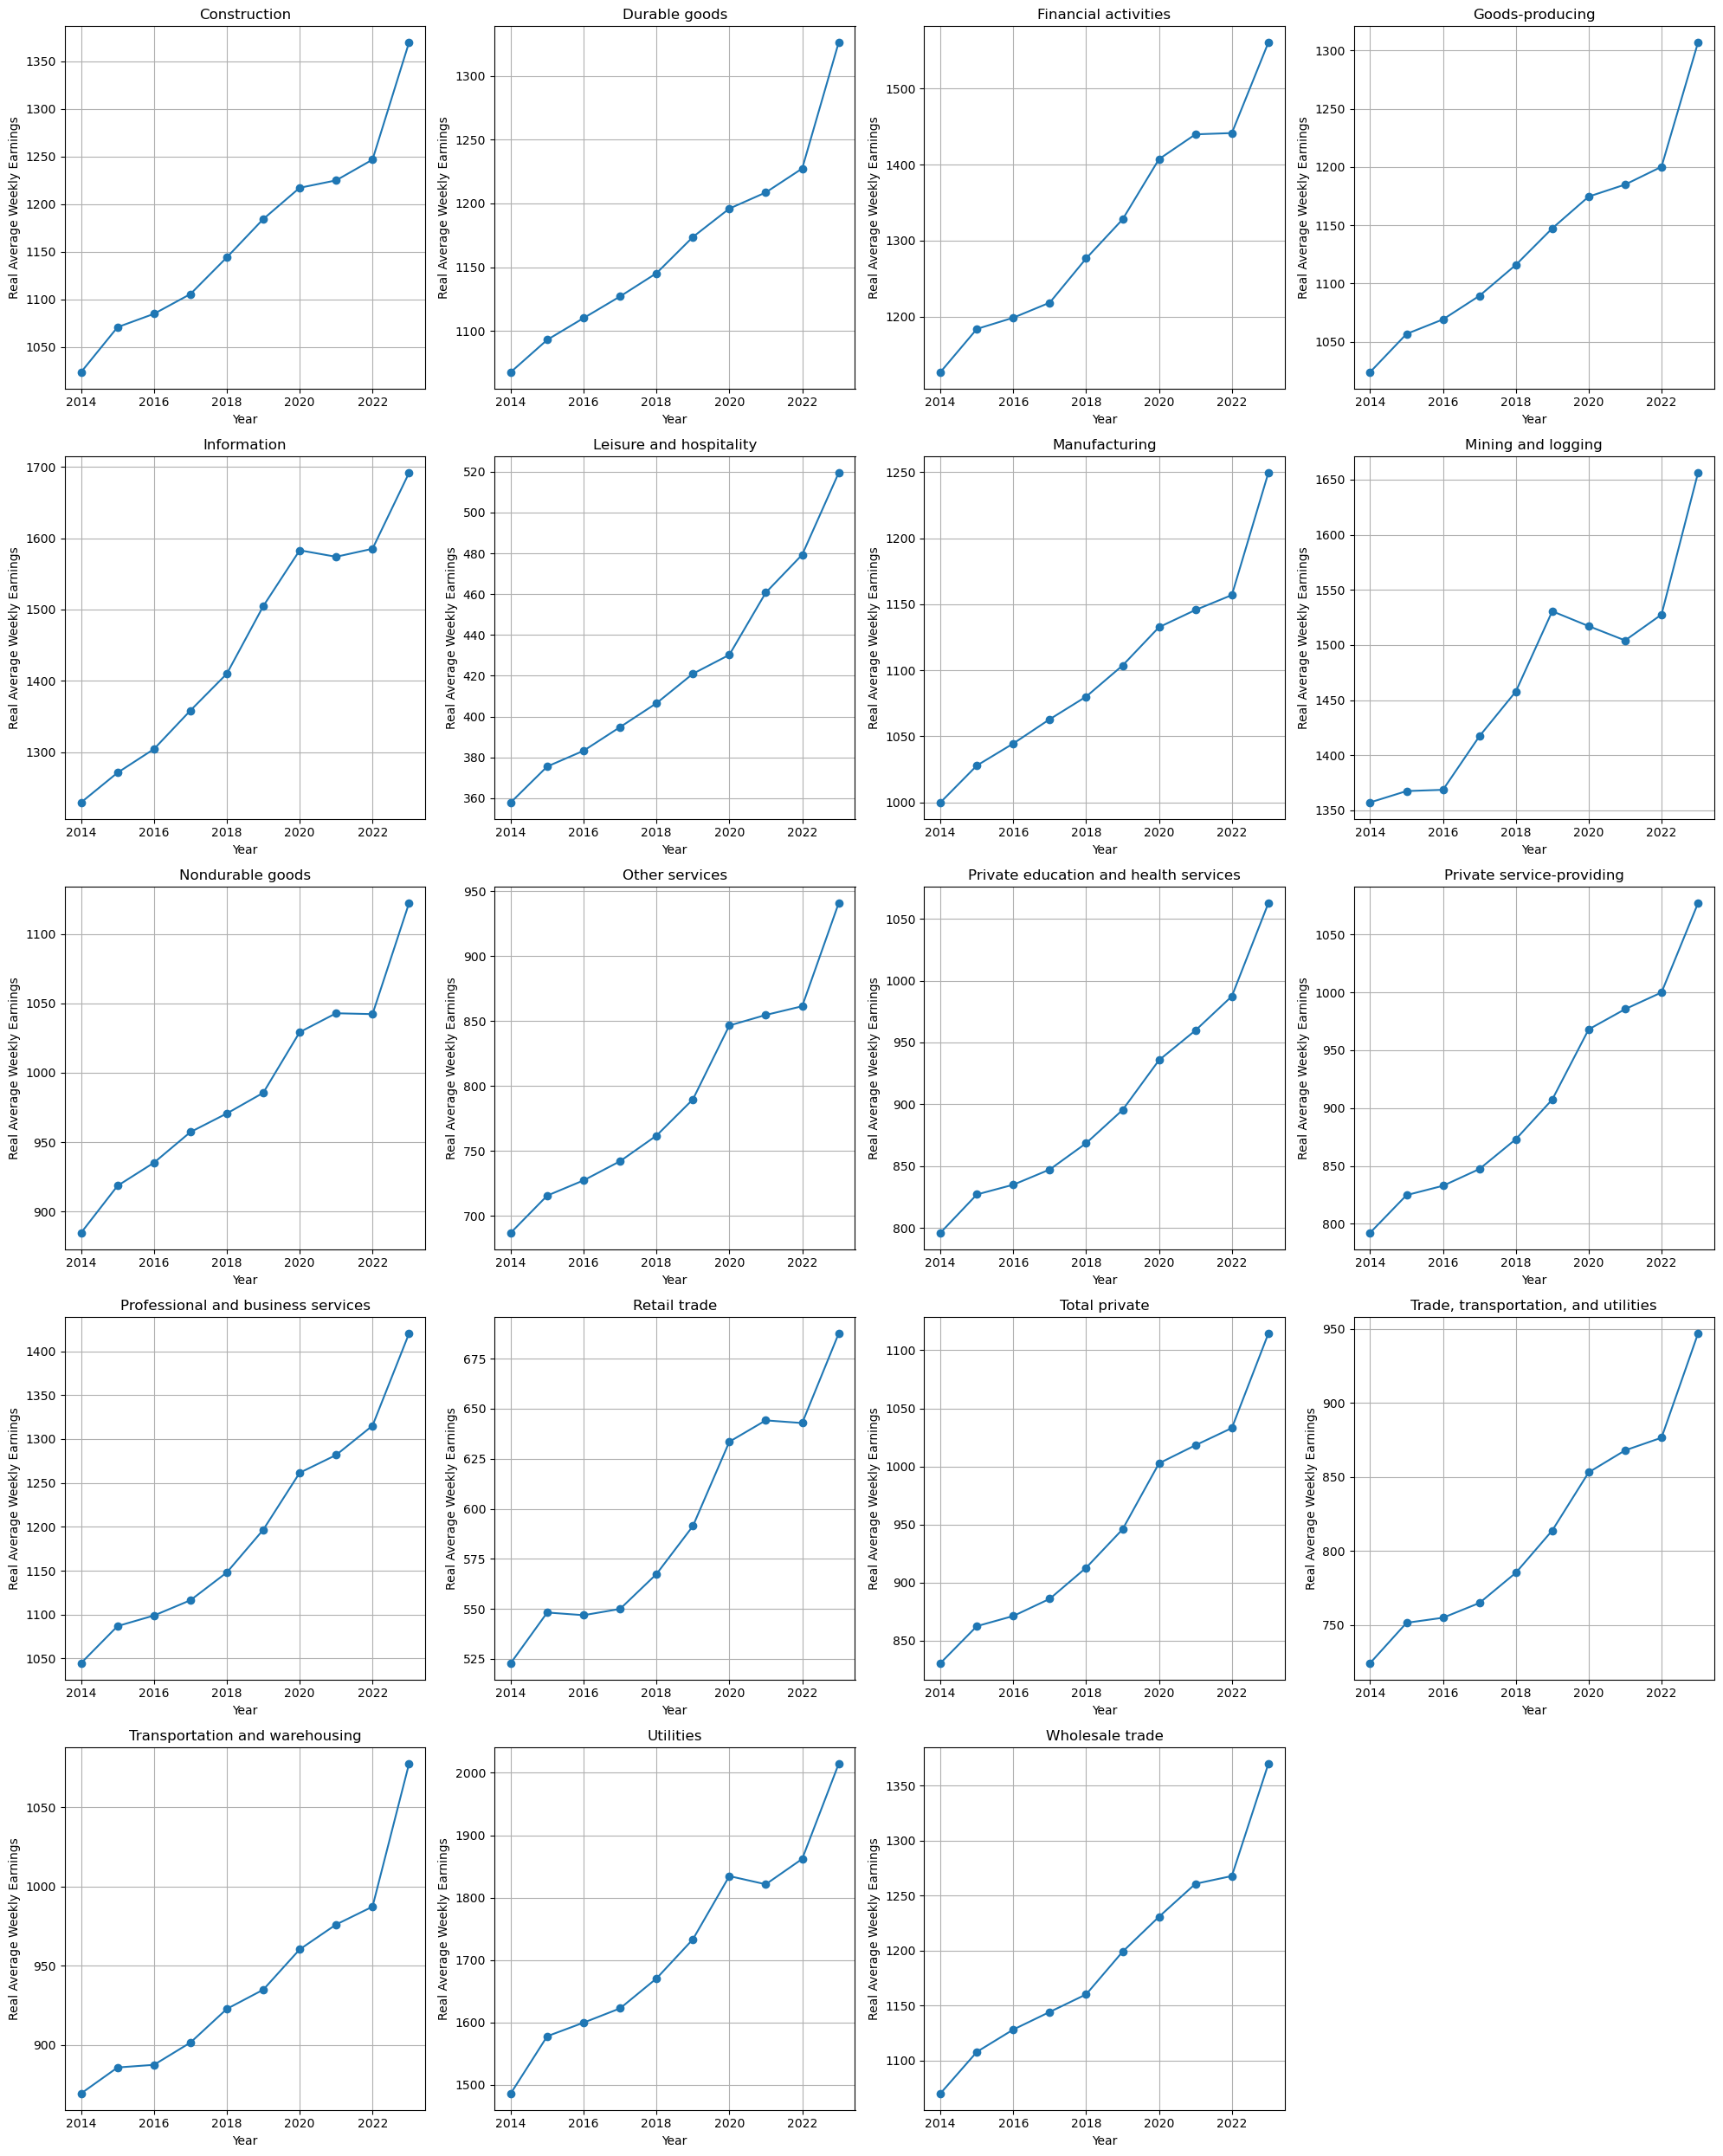

In [8]:
# Recreate the grid of subplots for each industry
fig, axs = plt.subplots(5, 4, figsize=(20, 25), dpi=100)  # Adjusting the number of rows and columns to fit all 19 industries

# Check the number of distinct industries and display their names
distinct_industries = df['industry'].unique()
distinct_industries, len(distinct_industries)


# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot each industry in its respective subplot
for i, industry in enumerate(distinct_industries):
    axs[i].plot(df_grouped.columns, df_grouped.loc[industry], label=industry, marker='o')
    axs[i].set_title(industry)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Real Average Weekly Earnings')
    axs[i].grid(True)

# Hide any unused axes
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

fig.tight_layout()
plt.show()


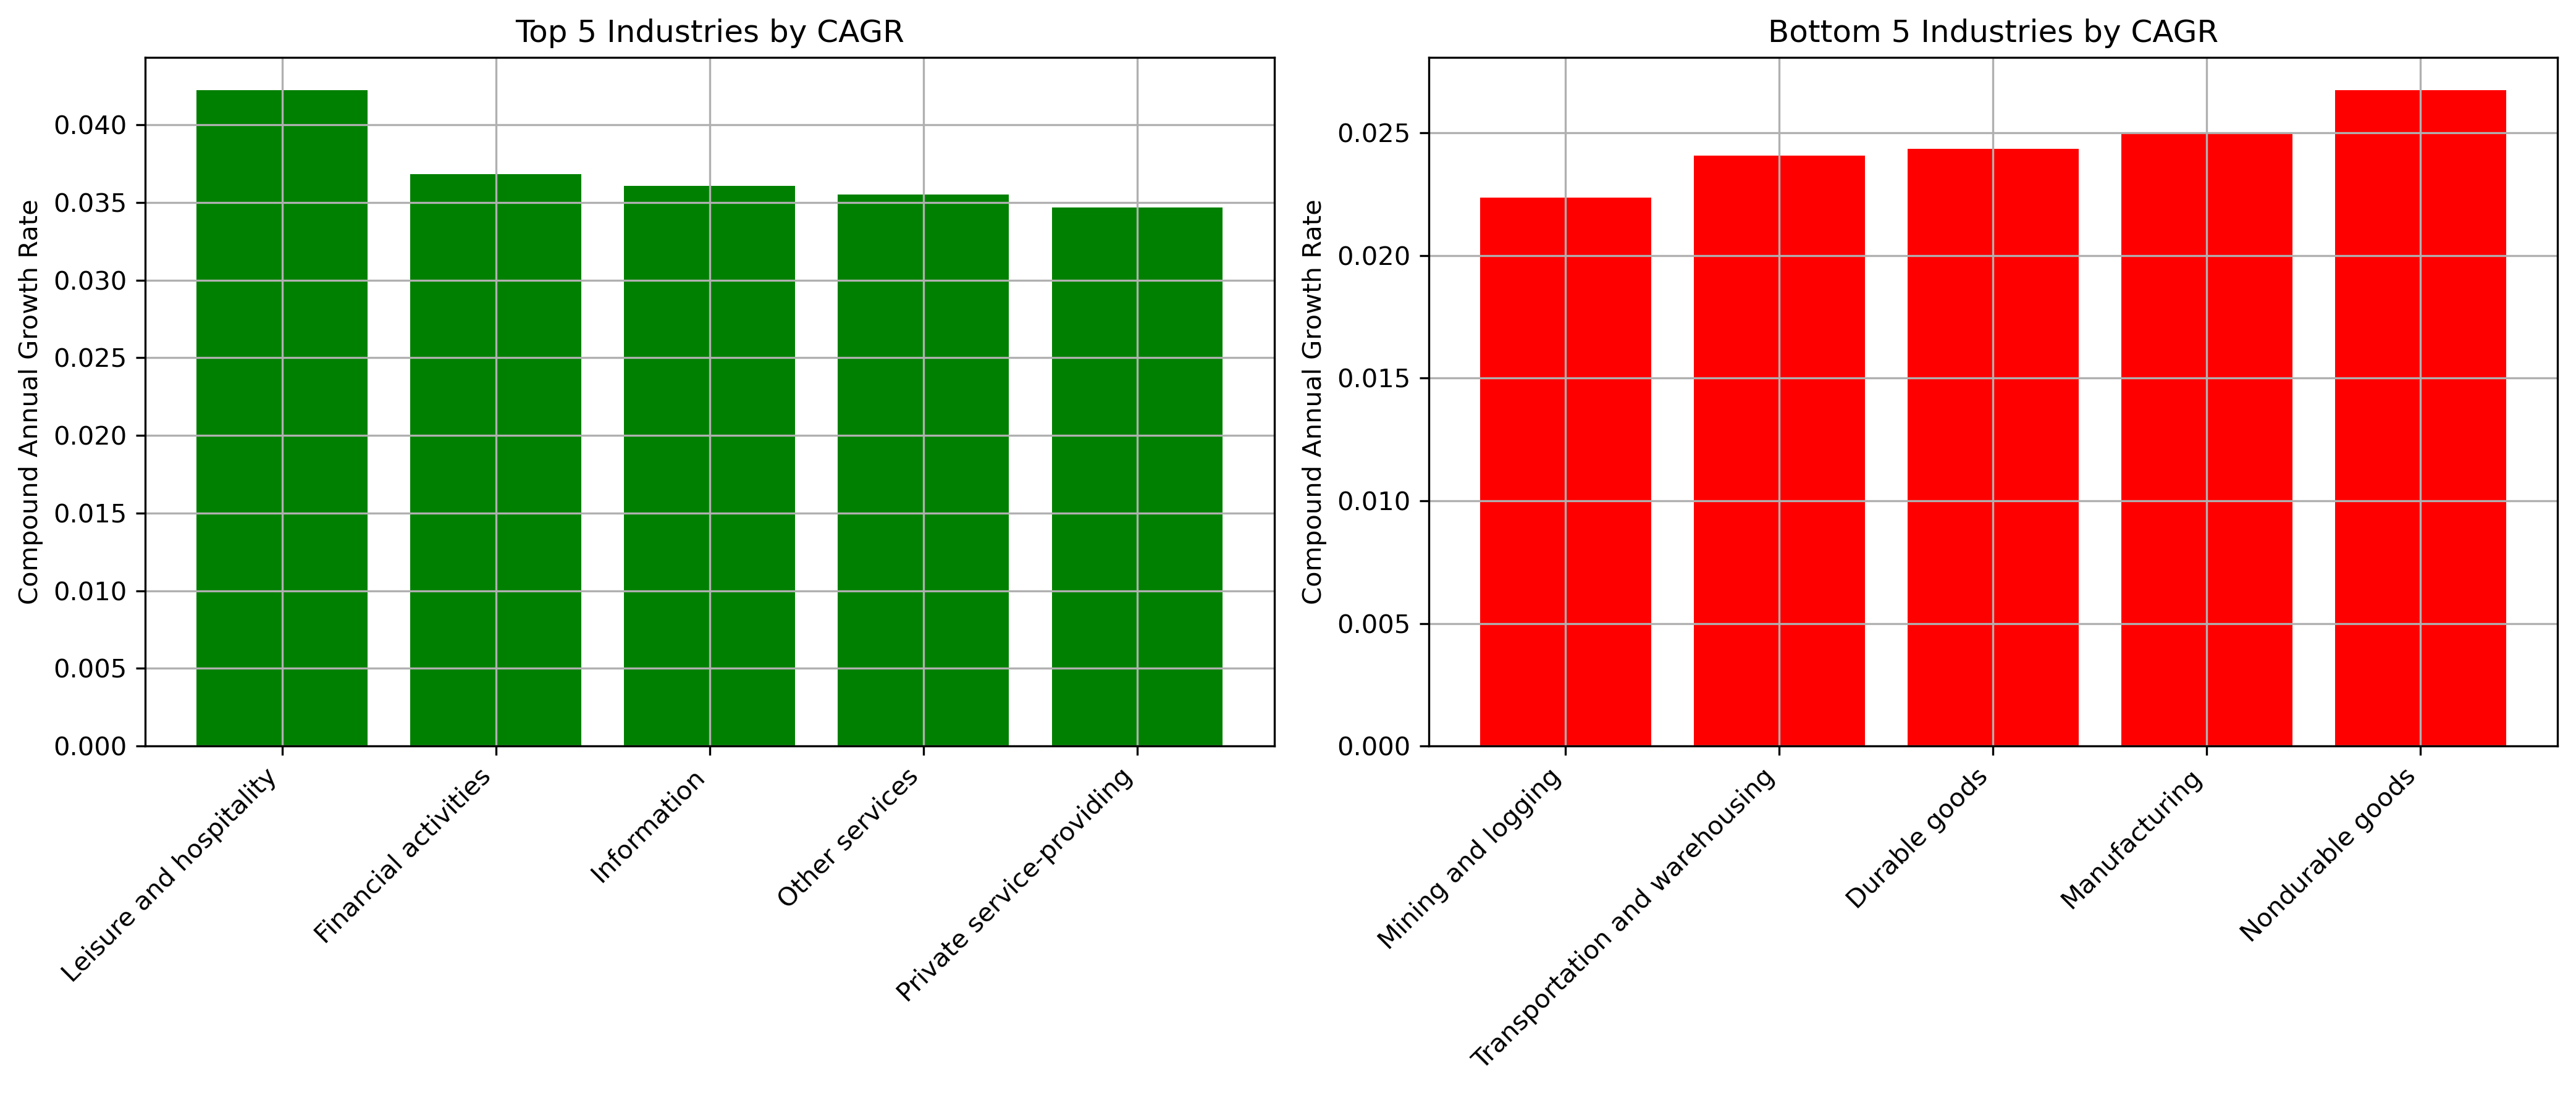

(industry
 Leisure and hospitality      0.042236
 Financial activities         0.036842
 Information                  0.036087
 Other services               0.035532
 Private service-providing    0.034690
 dtype: float64,
 industry
 Mining and logging                0.022354
 Transportation and warehousing    0.024080
 Durable goods                     0.024351
 Manufacturing                     0.025037
 Nondurable goods                  0.026744
 dtype: float64)

In [9]:
# Calculating the compound annual growth rate (CAGR) for each industry from 2014 to 2023

def calculate_cagr(start_value, end_value, periods):
    return (end_value/start_value)**(1/periods) - 1

# Apply CAGR calculation across the industries
cagr = df_grouped.apply(lambda row: calculate_cagr(row[2014], row[2023], 2023-2014), axis=1)

# Sort the CAGRs to find the top 5 and bottom industries
top_5_cagr = cagr.sort_values(ascending=False).head(5)
bottom_cagr = cagr.sort_values().head(5)

# Create a plot to display this information
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), dpi=300)

# Top 5 industries
ax1.bar(top_5_cagr.index, top_5_cagr.values, color='green')
ax1.set_title('Top 5 Industries by CAGR')
ax1.set_ylabel('Compound Annual Growth Rate')
ax1.set_xticklabels(top_5_cagr.index, rotation=45, ha="right")
ax1.grid(True)

# Bottom 5 industries
ax2.bar(bottom_cagr.index, bottom_cagr.values, color='red')
ax2.set_title('Bottom 5 Industries by CAGR')
ax2.set_ylabel('Compound Annual Growth Rate')
ax2.set_xticklabels(bottom_cagr.index, rotation=45, ha="right")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Display top 5 and bottom growth rates with their industries
top_5_cagr, bottom_cagr


### Top 5 Industries by CAGR:
- **Leisure and Hospitality**: 4.22%
- **Financial Activities**: 3.68%
- **Information**: 3.61%
- **Other Services**: 3.55%
- **Private Service-Providing**: 3.47%

### Bottom 5 Industries by CAGR:
- **Mining and Logging**: 2.24%
- **Transportation and Warehousing**: 2.41%
- **Durable Goods**: 2.44%
- **Manufacturing**: 2.50%
- **Nondurable Goods**: 2.67%

### Observations:
- **Leisure and Hospitality** leads with the highest growth rate, possibly reflecting recovery and expansion post-economic downturns or specific industry advancements.
- Industries like **Financial Activities** and **Information** also show strong growth, likely driven by technological advancements and increased demand for digital services.
- On the other end, **Mining and Logging**, along with **Transportation and Warehousing**, exhibit the slowest growth rates. This could be due to various factors such as market saturation, regulatory challenges, or slower technological adoption.
gical adoption.

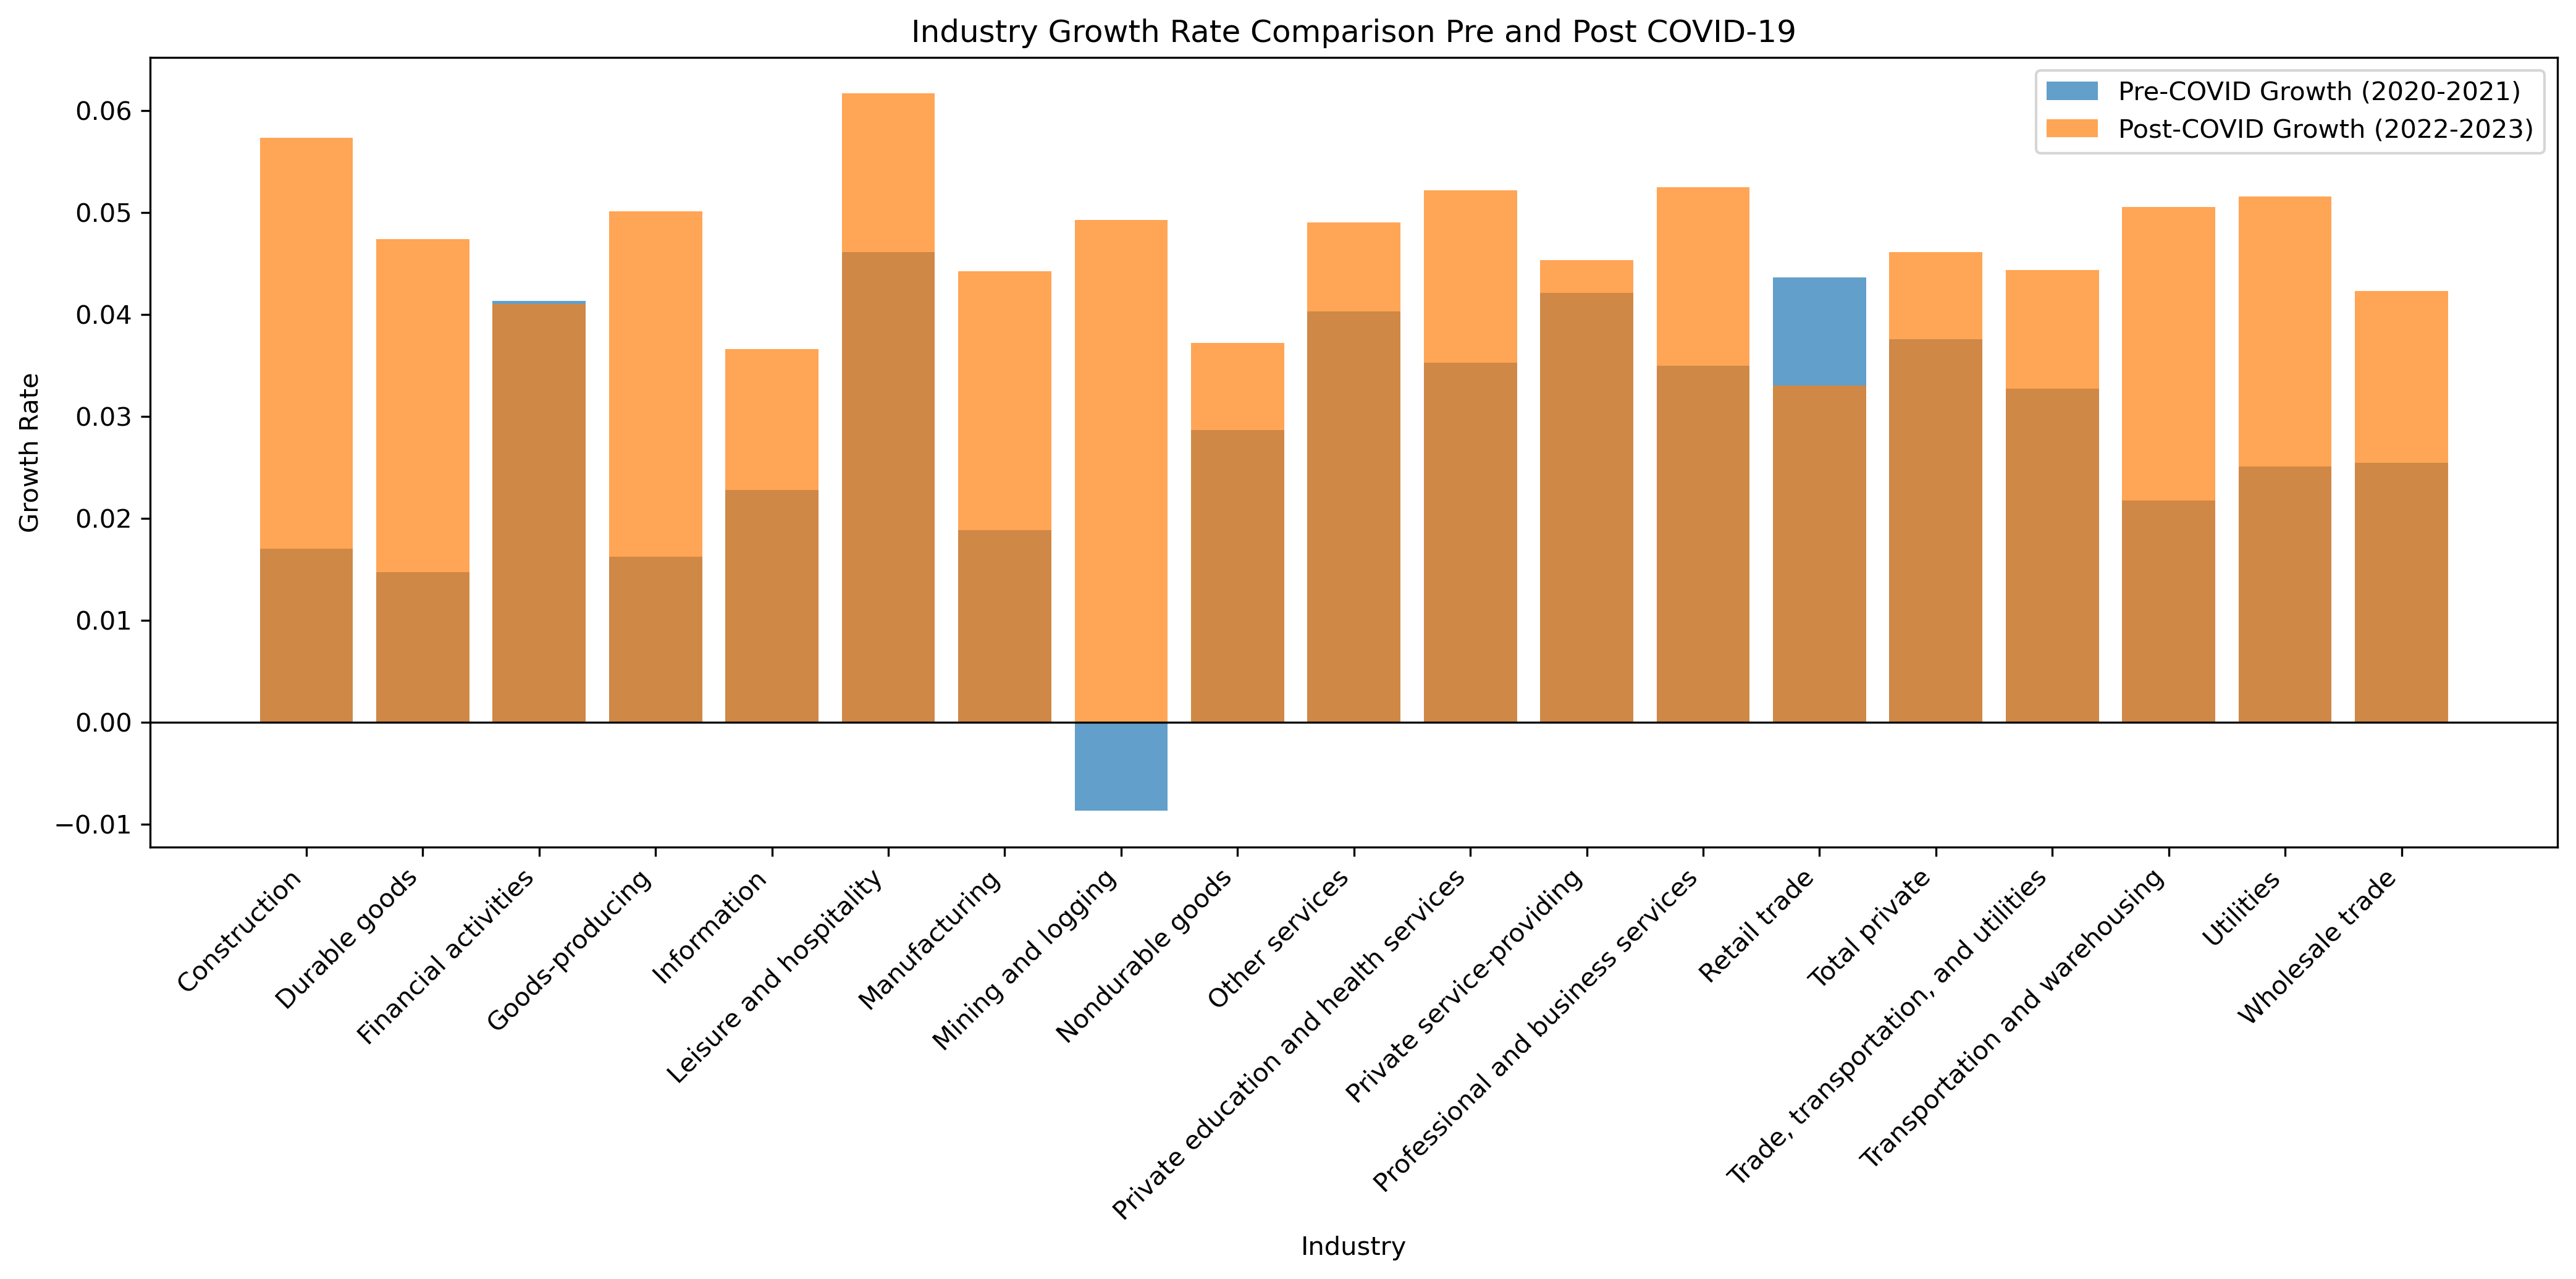

(0.03259463810462626,
 0.031156657186643556,
 industry
 Construction                             False
 Durable goods                            False
 Financial activities                      True
 Goods-producing                          False
 Information                              False
 Leisure and hospitality                  False
 Manufacturing                            False
 Mining and logging                       False
 Nondurable goods                         False
 Other services                           False
 Private education and health services    False
 Private service-providing                False
 Professional and business services       False
 Retail trade                              True
 Total private                            False
 Trade, transportation, and utilities     False
 Transportation and warehousing           False
 Utilities                                False
 Wholesale trade                          False
 dtype: bool,
 industry
 Construc

In [10]:
# Calculate median and mean CAGR from the previously calculated CAGR values
cagr_median = cagr.median()
cagr_mean = cagr.mean()

# Calculate growth rates for the period just before and after COVID-19 pandemic onset (2020-2021 vs 2022-2023)
growth_pre_pandemic = df_grouped.apply(lambda row: calculate_cagr(row[2019], row[2021], 2021-2019), axis=1)
growth_post_pandemic = df_grouped.apply(lambda row: calculate_cagr(row[2021], row[2023], 2023-2021), axis=1)

# Identify industries with different impacts
industries_decline = growth_post_pandemic < growth_pre_pandemic  # Industries where growth rate declined
industries_stable_or_grow = growth_post_pandemic >= growth_pre_pandemic  # Industries with minimal impact or growth

# Create a plot to visualize the changes
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)
ax.bar(growth_pre_pandemic.index, growth_pre_pandemic.values, label='Pre-COVID Growth (2020-2021)', alpha=0.7)
ax.bar(growth_post_pandemic.index, growth_post_pandemic.values, label='Post-COVID Growth (2022-2023)', alpha=0.7)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticklabels(growth_pre_pandemic.index, rotation=45, ha="right")
ax.set_title('Industry Growth Rate Comparison Pre and Post COVID-19')
ax.set_xlabel('Industry')
ax.set_ylabel('Growth Rate')
ax.legend()

plt.tight_layout()
plt.show()

# Output median and mean CAGR, and check industries impact
cagr_median, cagr_mean, industries_decline, industries_stable_or_grow


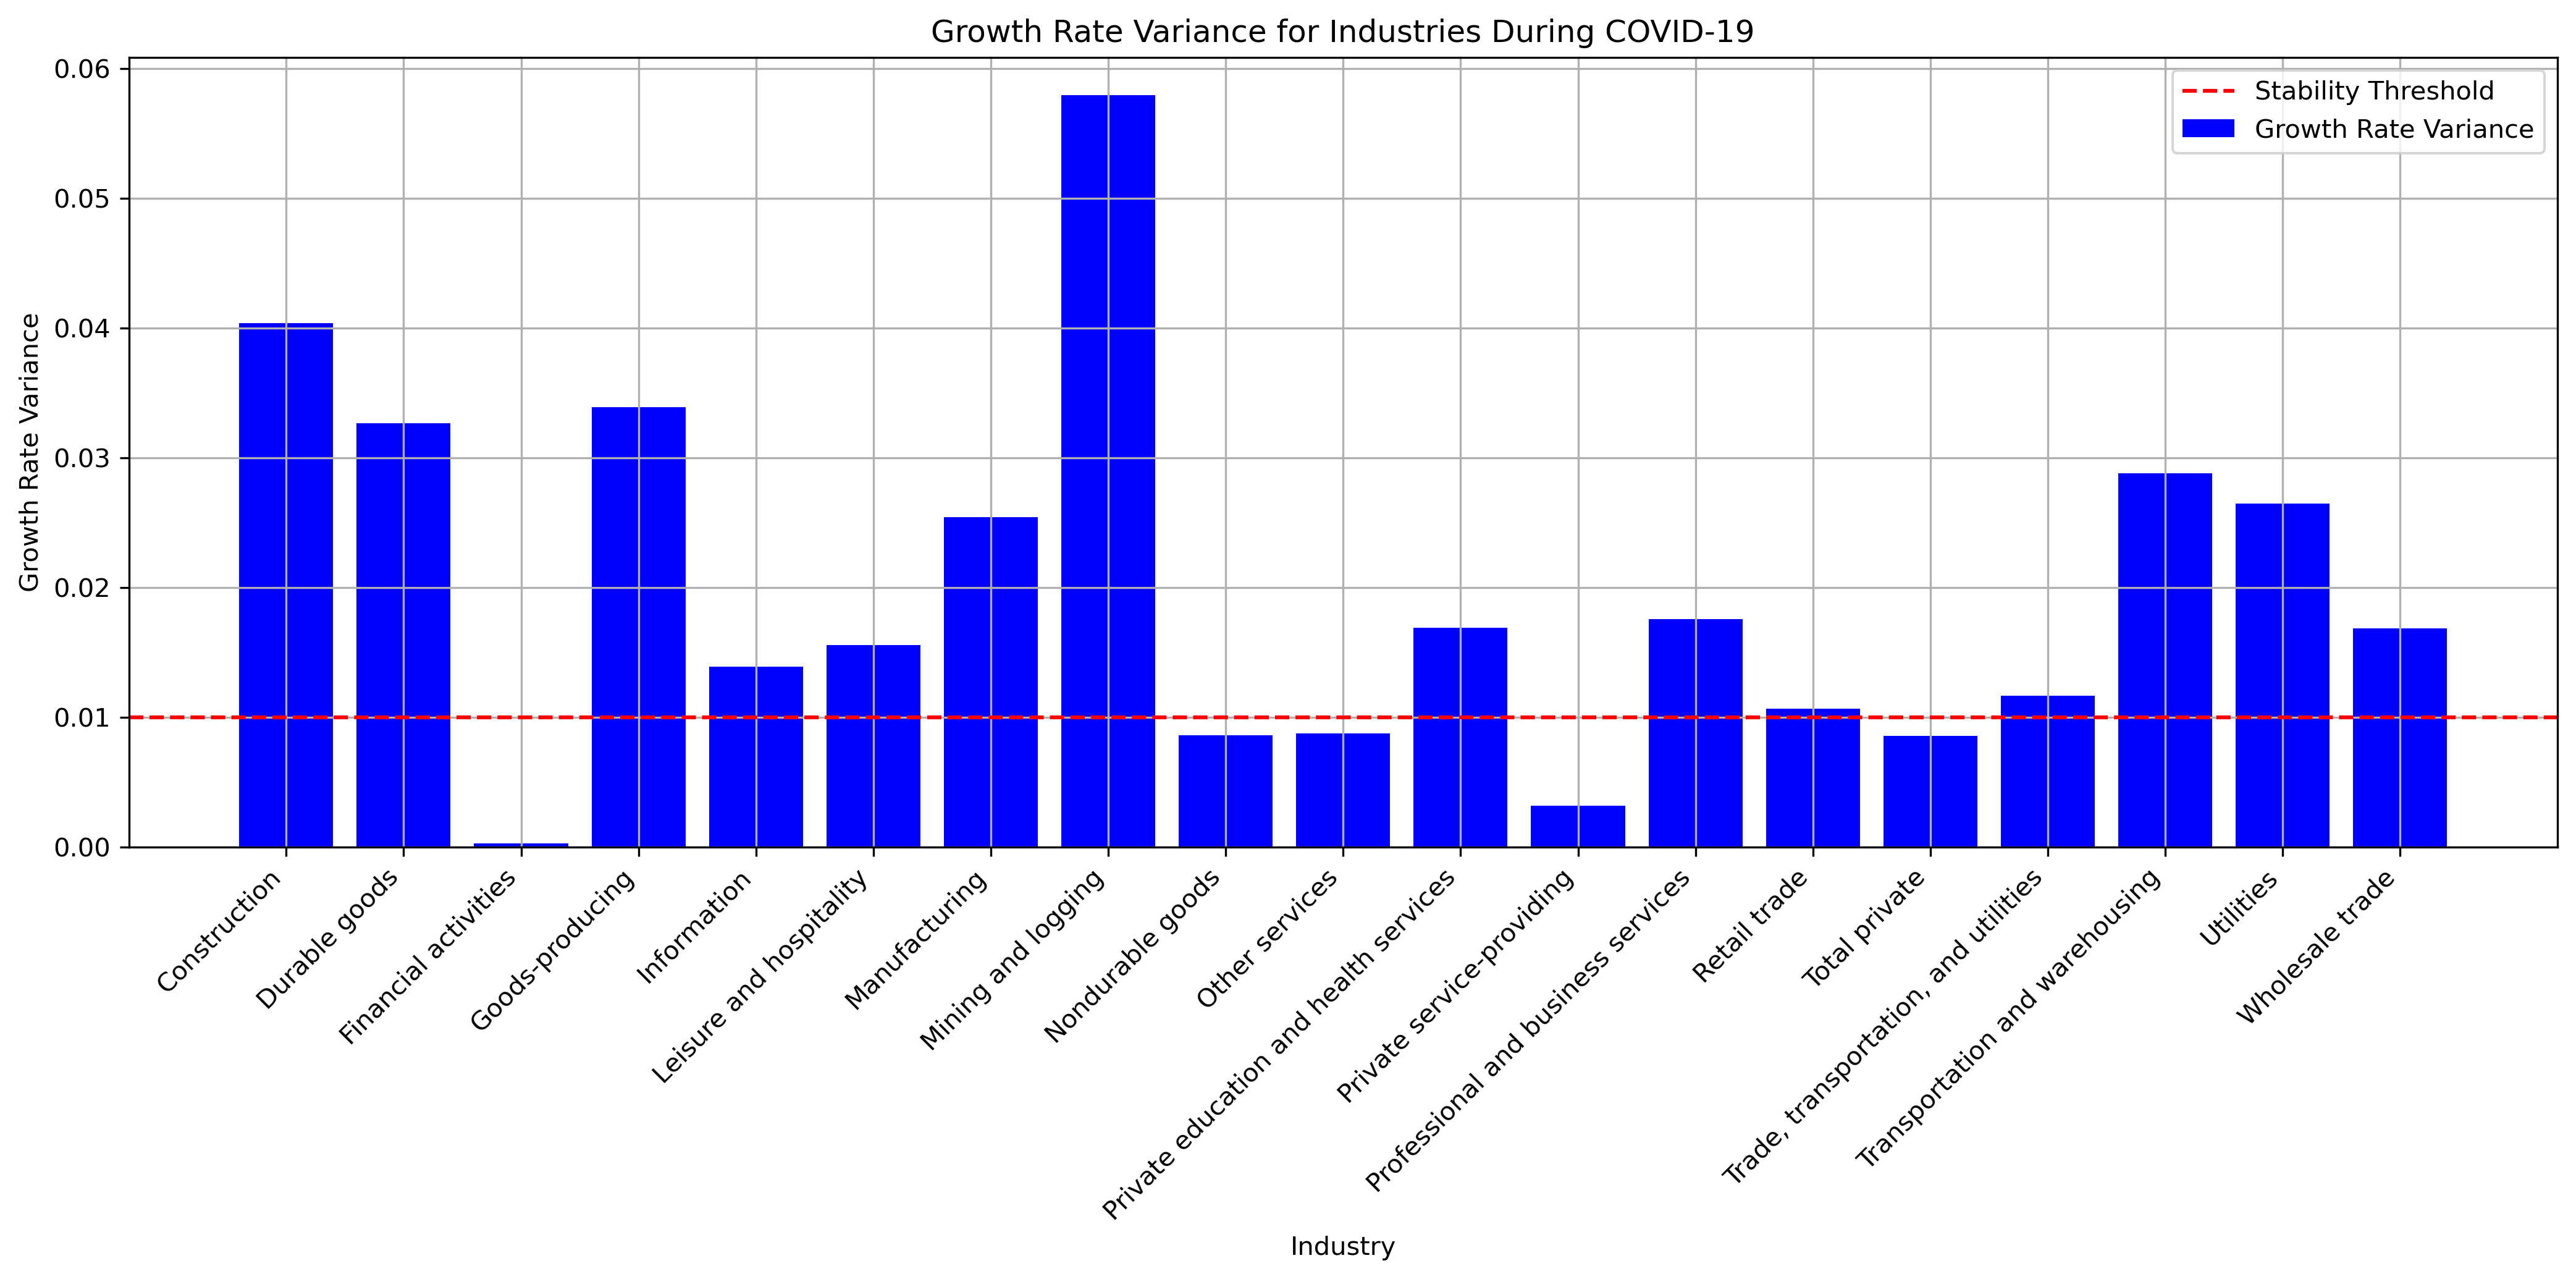

industry
Construction                             False
Durable goods                            False
Financial activities                      True
Goods-producing                          False
Information                              False
Leisure and hospitality                  False
Manufacturing                            False
Mining and logging                       False
Nondurable goods                          True
Other services                            True
Private education and health services    False
Private service-providing                 True
Professional and business services       False
Retail trade                             False
Total private                             True
Trade, transportation, and utilities     False
Transportation and warehousing           False
Utilities                                False
Wholesale trade                          False
dtype: bool

In [11]:
# Calculate the variance in growth rates to identify stability
growth_variance = (growth_post_pandemic - growth_pre_pandemic).abs()

# Define stability threshold (e.g., changes less than 1% are considered stable)
stability_threshold = 0.01

# Industries with stable growth during COVID
industries_stable_during_covid = growth_variance <= stability_threshold

# Create a plot to visualize stability
fig, ax = plt.subplots(figsize=(14, 7), dpi=300)
ax.bar(growth_variance.index, growth_variance.values, color='blue', label='Growth Rate Variance')
ax.axhline(stability_threshold, color='red', linestyle='--', label='Stability Threshold')
ax.set_xticklabels(growth_variance.index, rotation=45, ha="right")
ax.set_title('Growth Rate Variance for Industries During COVID-19')
ax.set_xlabel('Industry')
ax.set_ylabel('Growth Rate Variance')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

# Output the stable industries based on the variance threshold
industries_stable_during_covid


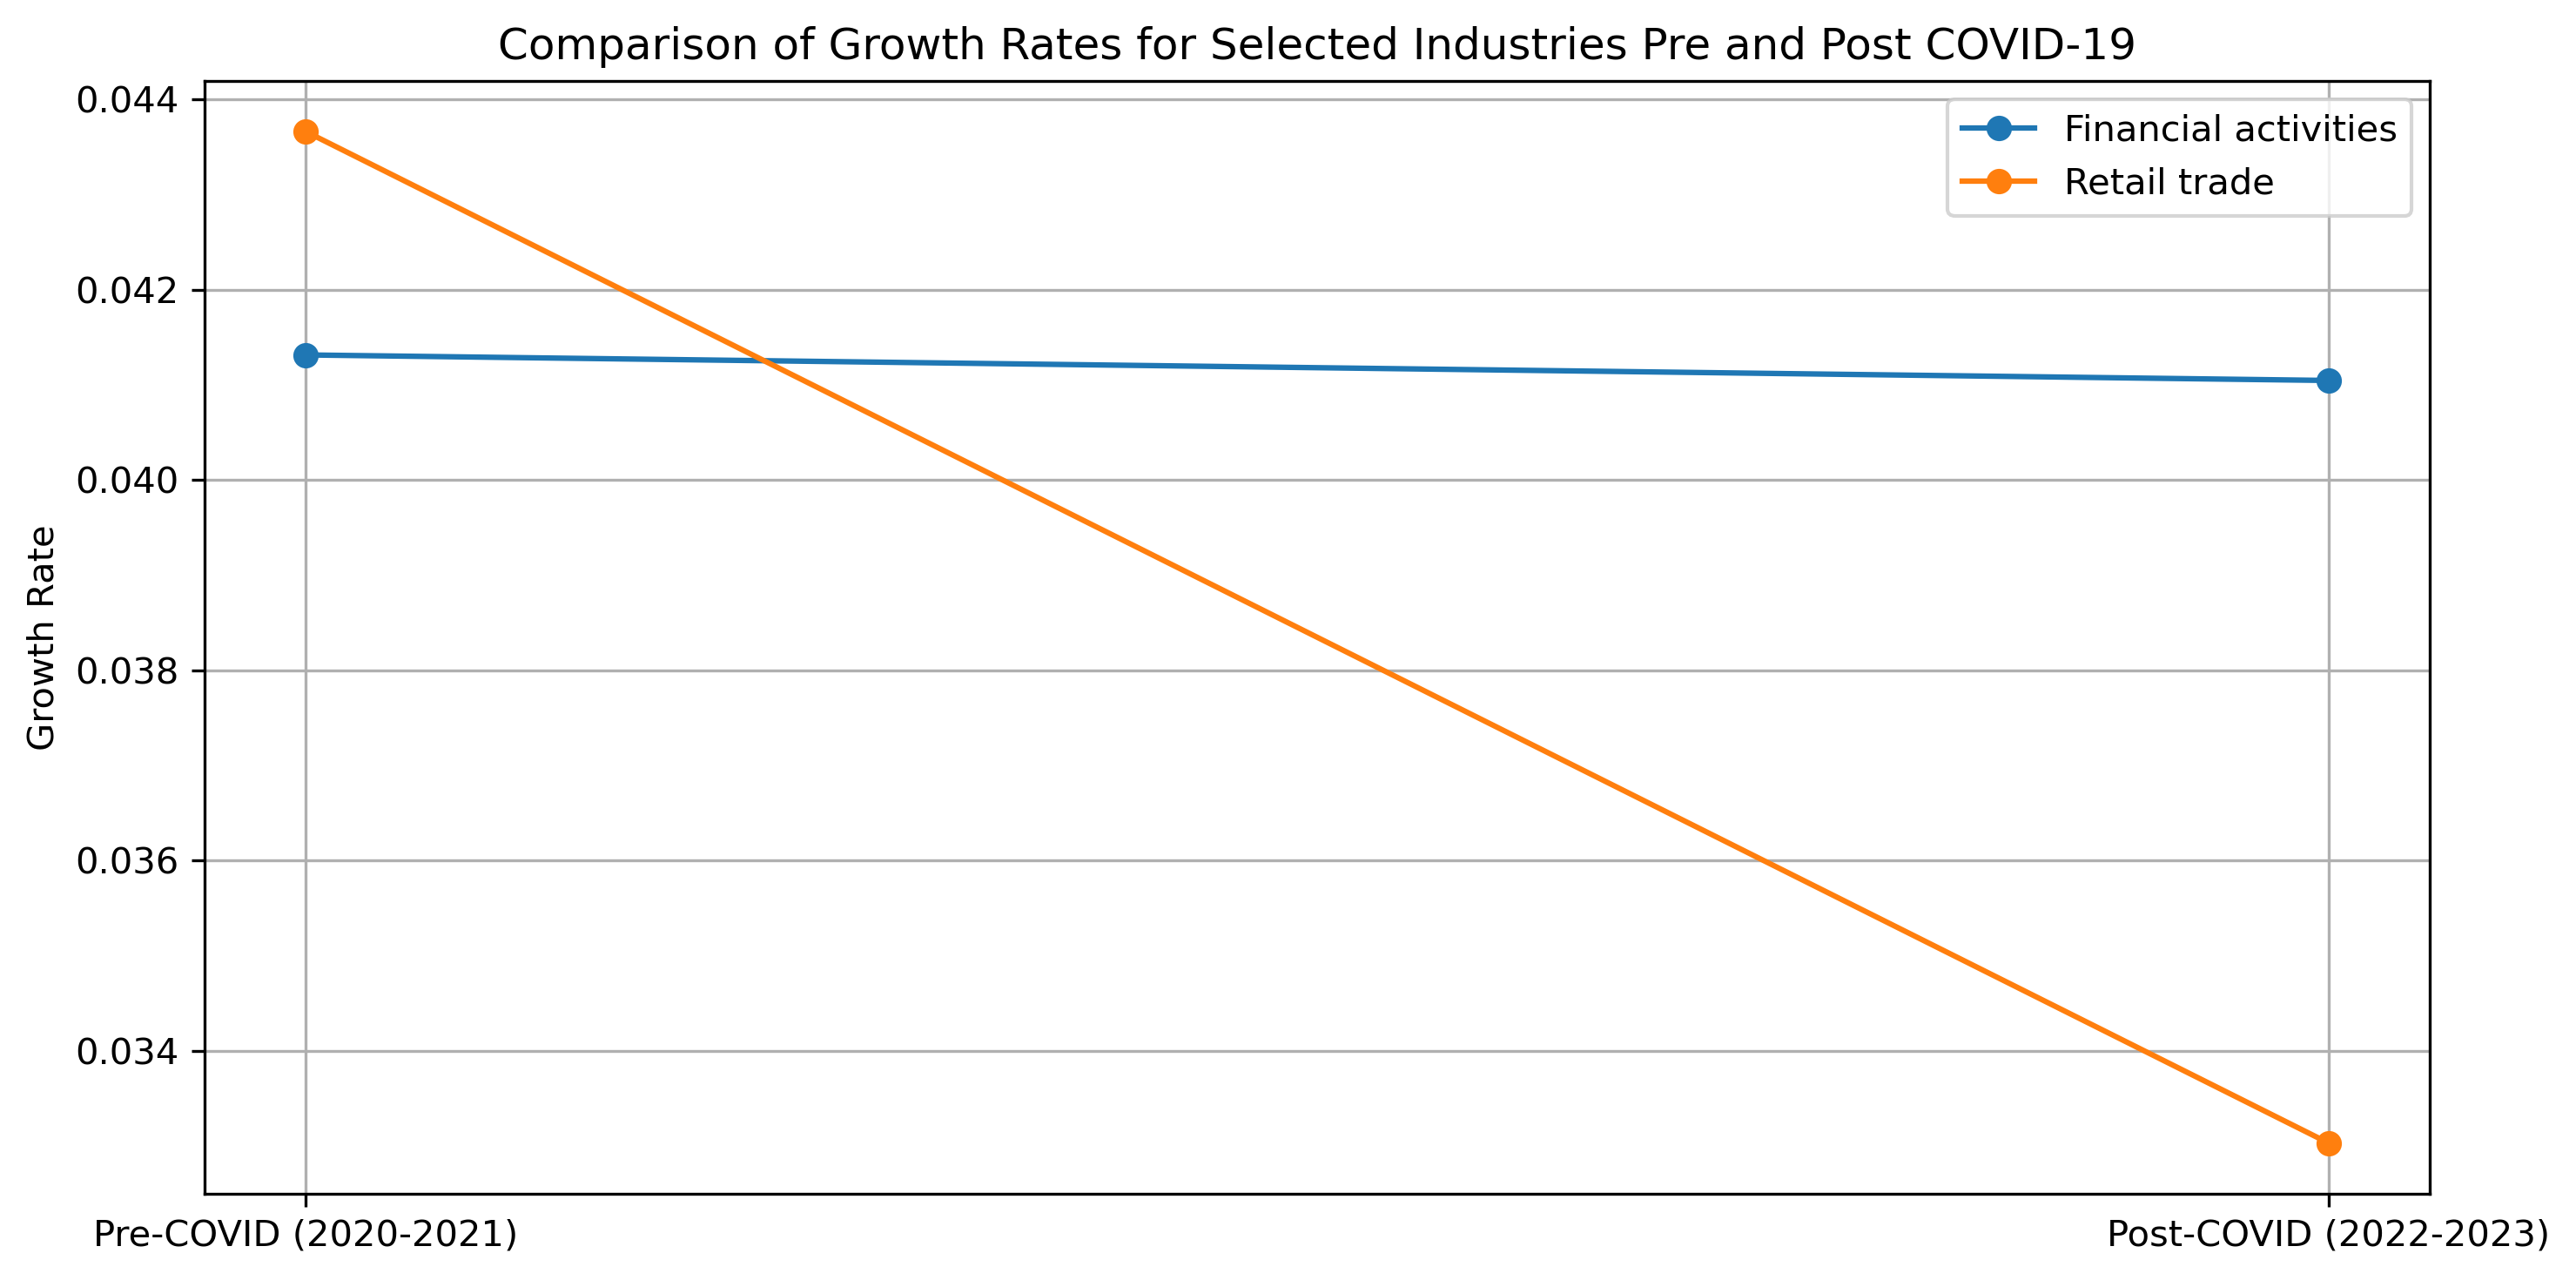

In [12]:
# Focusing on Financial Activities and Retail Trade for specific visualization
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
industries_to_focus = ['Financial activities', 'Retail trade']

# Plotting the growth rates for these industries
for industry in industries_to_focus:
    ax.plot(['Pre-COVID (2020-2021)', 'Post-COVID (2022-2023)'], 
            [growth_pre_pandemic[industry], growth_post_pandemic[industry]], 
            label=industry, marker='o')

ax.set_title('Comparison of Growth Rates for Selected Industries Pre and Post COVID-19')
ax.set_ylabel('Growth Rate')
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()


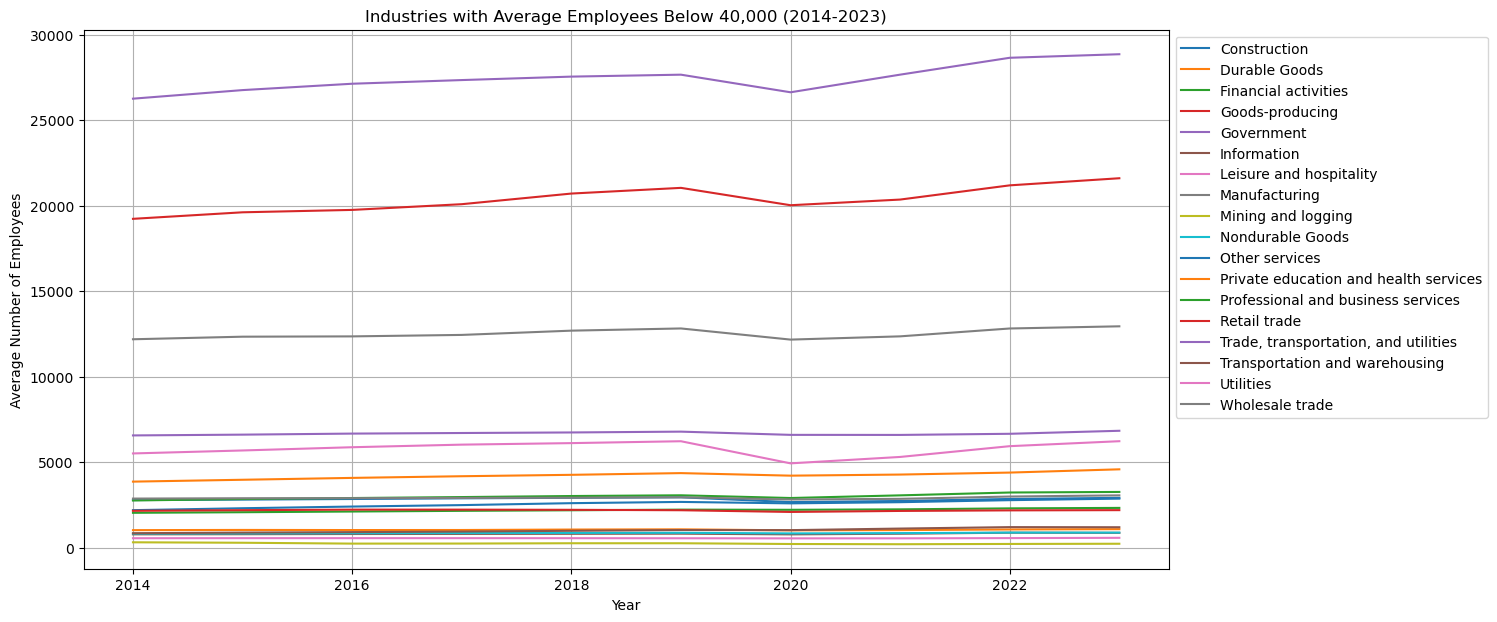

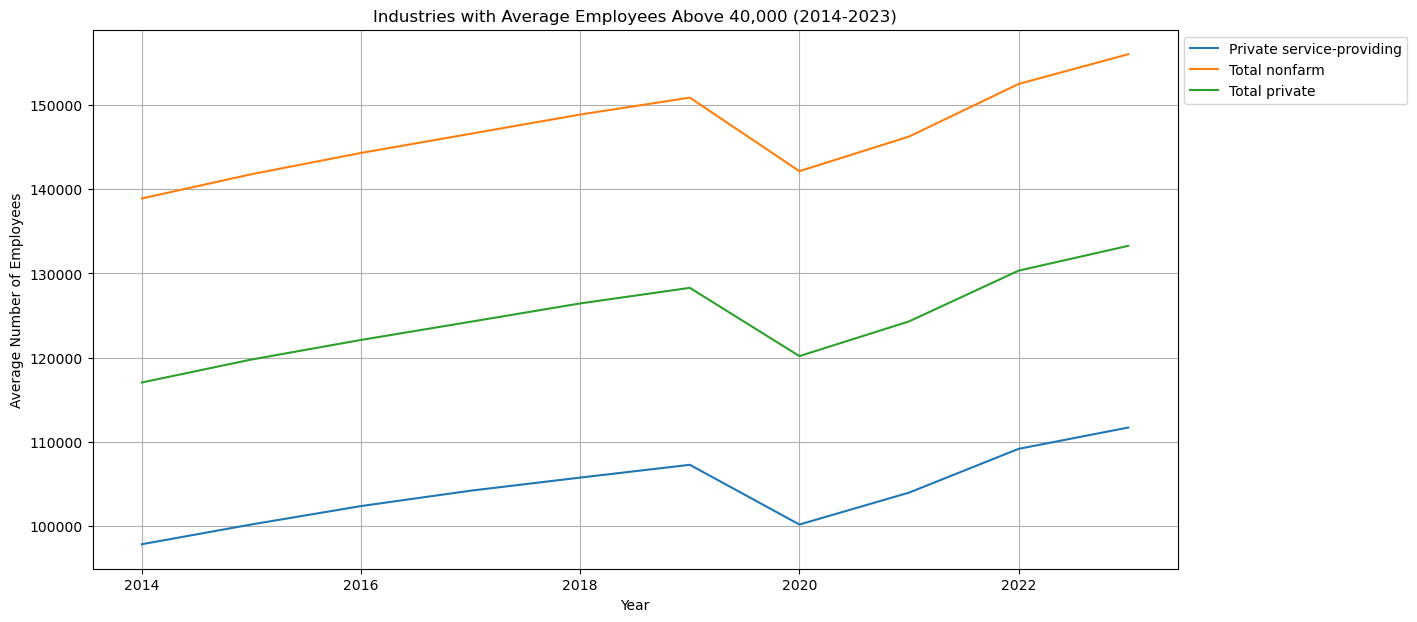

In [13]:
# Load the employee numbers data
employee_data_path = 'Data/data-bls-gov/Employees_Number_summary.csv'
employee_df = pd.read_csv(employee_data_path)

# Compute the average number of employees per year for each industry
employee_df['Average'] = employee_df.iloc[:, 1:13].mean(axis=1)
average_employees_by_year = employee_df.groupby(['Year', 'industry'])['Average'].mean().unstack()

# Separate the data into two groups based on the threshold of 40,000
below_40000 = average_employees_by_year.loc[:, (average_employees_by_year.mean() < 40000)]
above_40000 = average_employees_by_year.loc[:, (average_employees_by_year.mean() >= 40000)]

# Plotting function
def plot_data(data, title):
    plt.figure(figsize=(14, 7))
    for industry in data.columns:
        plt.plot(data.index, data[industry], label=industry)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Average Number of Employees')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

# Plot the data for industries with average below 40,000
plot_data(below_40000, 'Industries with Average Employees Below 40,000 (2014-2023)')

# Plot the data for industries with average above 40,000
plot_data(above_40000, 'Industries with Average Employees Above 40,000 (2014-2023)')


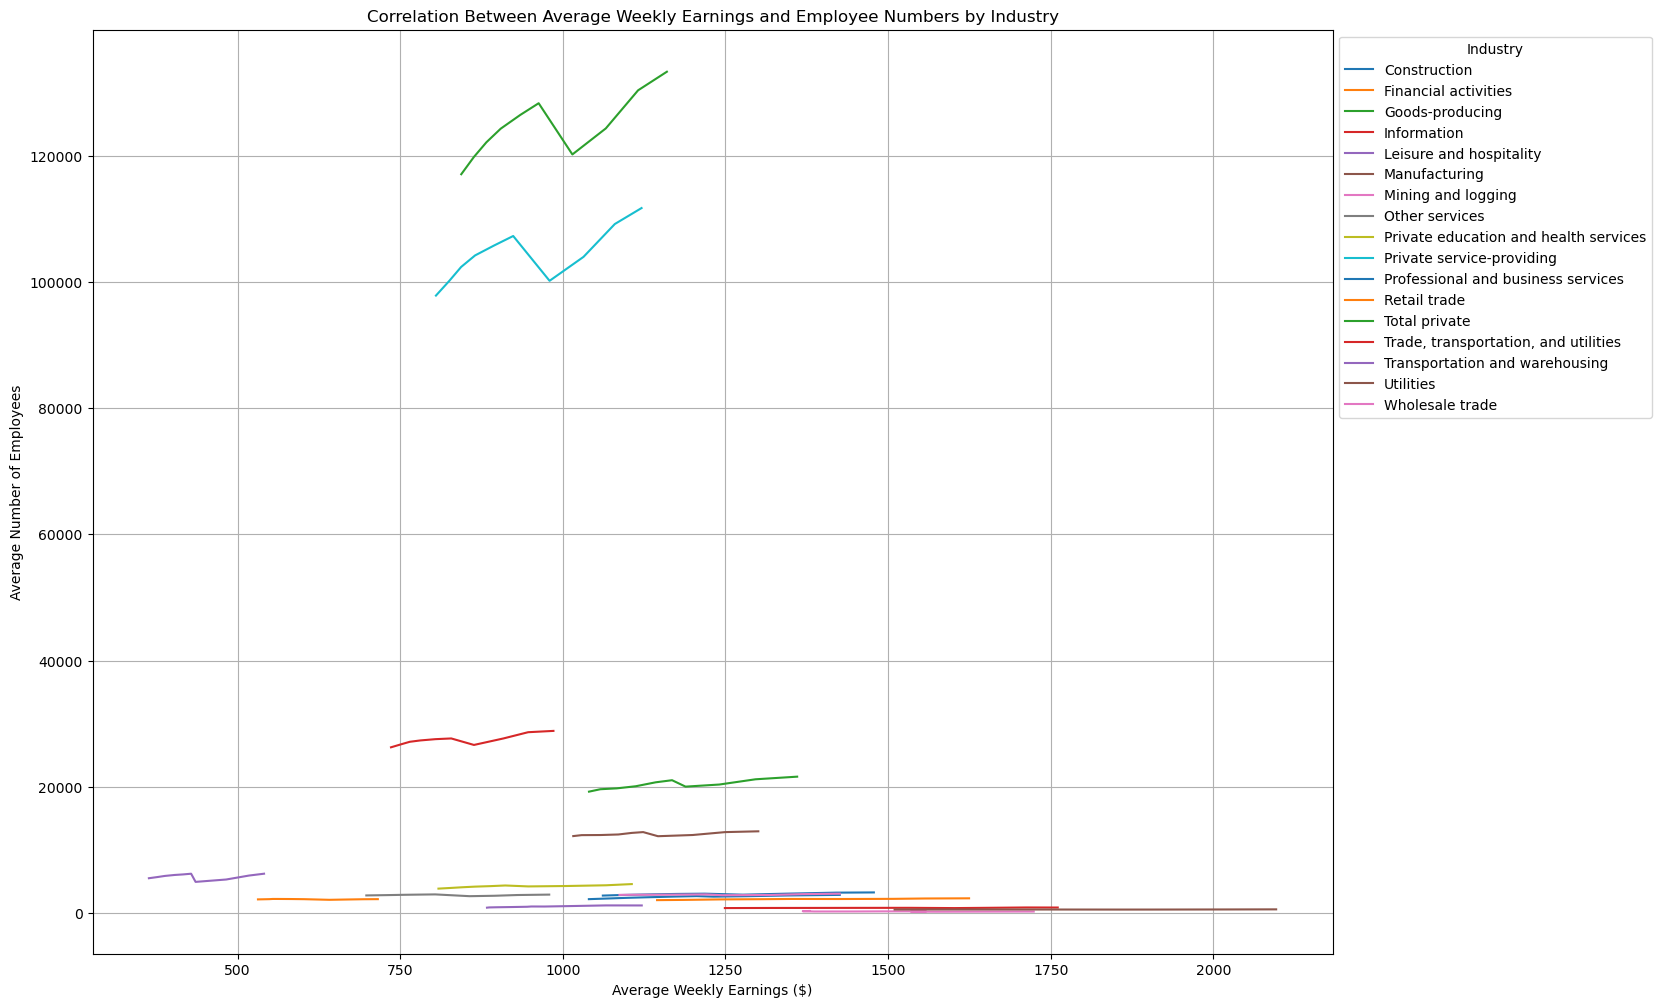

In [14]:
# Reload Earnings data
earnings_path = 'Data/data-bls-gov/Average_Weekly_Earnings_summary.csv'
earnings_df = pd.read_csv(earnings_path)
earnings_df['Annual Average'] = earnings_df.iloc[:, 1:13].mean(axis=1)
annual_average_earnings = earnings_df.groupby(['Year', 'industry'])['Annual Average'].mean().unstack()


# Merge and analyze
merged_data = annual_average_earnings.join(average_employees_by_year, lsuffix='_earnings', rsuffix='_employees')
correlation_data = merged_data.corr(method='pearson')

# Plotting
plt.figure(figsize=(16, 12))
for industry in earnings_df['industry'].unique():
    if f"{industry}_earnings" in merged_data and f"{industry}_employees" in merged_data:
        plt.plot(merged_data[f"{industry}_earnings"], merged_data[f"{industry}_employees"], label=industry)
plt.xlabel('Average Weekly Earnings ($)')
plt.ylabel('Average Number of Employees')
plt.title('Correlation Between Average Weekly Earnings and Employee Numbers by Industry')
plt.legend(title="Industry", loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()
